# **TP - Grupo 4**
Pedro Paulo Costa Pereira - A88062

Tiago André Oliveira Leite - A91693

# **Problema 1 - Sistema de Tráfego**

In [10]:
import networkx as nx
from ortools.linear_solver import pywraplp
import random

$\quad$ Um sistema de tráfego  é representado por um grafo orientado ligado. Os nodos denotam pontos de acesso e  os arcos denotam vias de comunicação só com um sentido . O grafo tem de ser ligado o que significa que entre cada par de nodos $\langle n_1,n_2 \rangle$ tem de existir um caminho $n_1 \leadsto n_2$ e um caminho $n_2\leadsto n_1$.<br>
$\quad$ 1. Gerar aleatoriamente um tal grafo com  $N=32$ nodos.  Cada nodo tem um número aleatório de descendentes no intervalo $\,1..3\,$  cujos destinos são distintos entre si do nodo origem.<br>
$\quad$ 2. Pretende-se fazer  manutenção interrompendo  determinadas vias. Determinar o maior número de vias que é possível remover mantendo o grafo ligado.

## Funções para gerar digrafo ligado

### Variaveis Globais

$NUM\_NODES =$ Número de nodos do digrafo.<br>
$MAX\_OUT\_DEGREE =$ Número maximo de descendentes de cada nodo

In [11]:
NUM_NODES = 32 
MAX_OUT_DEGREE = 3 

### Metodo 1

$\quad$ Neste metodo de geração do digrafo a estrategia utilizada consiste em manter manter sempre o digrafo ligado à medida que se vão adicionando arestas. Chamemos ao digrafo que vamos gerar **G**.<br>
$\quad$ Em primeiro lugar, inserimos todos os nodos [$n_1..n_j$] em **G**. De seguida, selecionamos de forma aleatoria dois nodos, aos quais chamemos **s** e **d** e adicionamos as arestas (**s**,**d**) e (**d**,**s**) a **G**. Apartir daqui, vamos ligando cada um dos nodos restantes a **G** de uma forma aleatoria, mas que mantenha sempre **G** ligado. Assim sendo, selecionamos um nodo **n** que ainda nao tem arestas e dois nodos, **s** e **d**, que ja se encontram na parte de **G** ligado. Aqui, existem duas opções:<br>
$\quad$ a. Se **s** ja tiver um grau de saida superior ao que foi definido, selecionamos outro nodo **d** que seja sucessor de **s**, removemos a aresta (**s**,**d**) e colocamos as arestas (**s**,**n**) e (**n**,**d**).<br>
$\quad$ b. Se **s** não tiver um grau de saida superior ao que foi definido, de forma aleatoriamente escolhida fazemos uma de duas coisas. Ou colocamos as arestas (**s**,**n**) e (**n**,**d**) ou então fazemos o mesmo processo definido no ponto a.<br>
$\quad$ Por fim iteramos por todos os nodos e adicionamos as restantes arestas de forma a satisfazer as condições do enunciado.

In [12]:
def graph_generator():
    G = nx.DiGraph()

    nodes = [n for n in range(1,NUM_NODES+1)]
    choosen = []
    G.add_nodes_from(nodes)
    random.shuffle(nodes)
    
    s = random.choice(nodes)
    nodes.remove(s)
    choosen.append(s)
    d = random.choice(nodes)
    nodes.remove(d)
    choosen.append(d)
    
    G.add_edge(s,d)
    G.add_edge(d,s)
    
    while nodes:
        to_add = random.choice(nodes)
        nodes.remove(to_add)
        s = random.choice(choosen)
        d = random.choice(choosen)
        if G.out_degree(s) == MAX_OUT_DEGREE or random.choice([0,1]):
            d = random.choice(list(G.successors(s)))
            G.remove_edge(s,d)
            G.add_edge(s,to_add)
            G.add_edge(to_add,d)
        else:
            G.add_edge(s,to_add)
            G.add_edge(to_add,s)
        choosen.append(to_add)
    
    nodes = [n for n in G.nodes() if G.out_degree(n)<MAX_OUT_DEGREE]
    while nodes:
        s = nodes.pop()
        r = random.randint(0,MAX_OUT_DEGREE - G.out_degree(s))
        candidates = [n for n in G.nodes() if n != s]
        for i in range(r):
            d = random.choice(candidates)
            candidates.remove(d)
            G.add_edge(s,d)
            
    return G

### Metodo 2

$\quad$ Neste metodo, mais simples que o anterior, criamos o digrado **G** e adicionamos todos os nodos [ 𝑛1..𝑛𝑗 ] em **G**. De seguida adicionamos as arestas <br>($n_1, n_2$), ($n_2, n_3$)...($n_{j-1}, n_j$) e ($n_j, n_1$). Isto vai criar um ciclo. Por fim, iteramos por todos os nodos e adicionamos as restantes arestas de forma a satisfazer as condições do enunciado. 

In [13]:
def graph_generator_simple():
    G = nx.DiGraph()

    nodes = [v for v in range(1,NUM_NODES+1)]
    G.add_nodes_from(nodes)
    random.shuffle(nodes)

    for i in range(len(nodes)-1):
        G.add_edge(nodes[i], nodes[i+1])
    G.add_edge(nodes[len(nodes)-1],nodes[0])

    for n in nodes:
        candidates = [v for v in nodes if v != n]
        random.shuffle(candidates)
        num_adj = random.randint(0,MAX_OUT_DEGREE-1)
        for i in range(num_adj):
            G.add_edge(n, candidates[i])
    return G

## Função para gerar subdigrafo de G ligado e com número minimo de arestas

$\quad$ Para gerar um subdigrafo **S** ligado aprtir de **G** com um número minimo de arestas, vamos utilizar um Solver SCIP ao qual chamaremos **solver** e dois dicionarios **A** e **P** onde vamos armazenar as variaveis do Solver.<br>
$\quad$ Seja **E** o conjunto das arestas de **G**, por cada aresta **e** pertencente a **E** vamos, em primeiro lugar, adicionar a **A** uma variavel binaria que represente a presença de **e** em **S**.<br> 
$\quad$ Para que um digrafo seja ligado, apenas precisamos de garantir que existe pelo menos um caminho de um nodo **s** para todos os outros nodos e que de cada um dos outros nodos existe pelo menos um caminho para **n**.<br>
$\quad$ Seja **L** um dicionario que armazena o conjunto de todos os caminhos entre dois pares de nodos, **s** e **d**,  de **G**, tal que $L_{n,d,i}$ é a lista das arestas  no caminho **i** ente **n** e **d** em **G**, vamos guardar  em **P** as variavies que representam a existencia desse caminho em **S**, ou seja, $P_{n,d,i} == 1$ significa que em **S** existe o caminho entre **n** e **s** formado por todas as arestas **e** pertencentes $L_{n,d,i}$ .<br>
$\quad$ Falta agora adicionar as retrições. Chamemos **s** ao nodo apartir do qual tera que existir um caminho para todos os outros e chamemos **D** ao conjunto formados por todos os outros nodos **d**. Adicionamos as seguintes restrições ao Solver:<br>
$\quad$ - $\forall_{d \in D} \ \forall_{i \ \in \ len(L_{s,d)}}  \ P_{s,d,i} \le A[L_{s,d,i}] $<br>
$\quad$ - $\sum_{i \ \in \ len(L_{s,d)}} P_{s,d,i} \ge 1 $<br>
$\quad$ - $\forall_{d \in D} \ \forall_{i \ \in \ len(L_{d,s)}}  \ P_{d,s,i} \le A[L_{d,s,i}] $<br>
$\quad$ - $\sum_{i \ \in \ len(L_{d,s)}} P_{d,s,i} \ge 1 $<br>
$\quad$ - $Minimizar \sum_{e \ \in E} A[e]$





In [9]:
def sub_graph_generator(G):
    solver = pywraplp.Solver.CreateSolver('SCIP')
    
    A = {}
    
    for edge in G.edges():
        A[edge] = solver.BoolVar('%i%i' %edge)
    
    
    
    nodes = [e for e in G.nodes()]
    s = nodes.pop(0)
    
    P = {}
    
    #garantir que de s conseguimos chegar a todos os outros nodos d e de todos os nodos d chegamos a s
    
    for d in nodes:
        
        #garantir que ha caminho de s para d
        
        paths = list(nx.all_simple_edge_paths(G, s, d))
        N = len(paths)
        for i in range(N):
            P[(s,d,i)] = solver.BoolVar('%i%i%i' %(s,d,i))
            for edge in paths[i]:
                solver.Add(P[(s,d,i)] <= A[edge])
        solver.Add(sum([P[(s,d,i)] for i in range(N)])>=1)
        
        #garantir que ha caminho de d para s
        
        paths = list(nx.all_simple_edge_paths(G, d, s))
        N = len(paths)
        for i in range(N):
            P[(d,s,i)] = solver.BoolVar('%i%i%i' %(d,s,i))
            for edge in paths[i]:
                solver.Add(P[(d,s,i)] <= A[edge])
        solver.Add(sum([P[(d,s,i)] for i in range(N)])>=1)
            
        
    
    solver.Minimize(sum([A[edge] for edge in G.edges]))
    status = solver.Solve()
    if status == pywraplp.Solver.OPTIMAL:
        S = nx.DiGraph()
        S.add_nodes_from(G.nodes())
        for edge in A:
            if A[edge].solution_value() == 1:
                S.add_edge(edge[0],edge[1])
        return S
    else:
        print("Sem solução")
                
                
    

## Exemplos

$\quad$Uma vez que o kernel do jupyter "morria" para a combição de 32 nodes com um maximo de 3 descendentes, resolvemos os seguintes exemplos com outras combinações.

### Exemplo 1

In [29]:
NUM_NODES = 32 
MAX_OUT_DEGREE = 2 

#### Gerar Digrafo - metodo 1

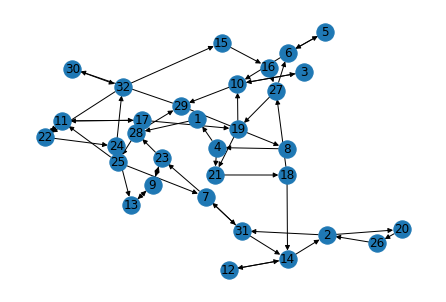

In [30]:
G1E1 = graph_generator()
nx.draw(G1E1, with_labels = True)

#### Verificar se é ligado 

In [31]:
nx.is_strongly_connected(G1E1)

True

#### Gerar Subgrafo minimal

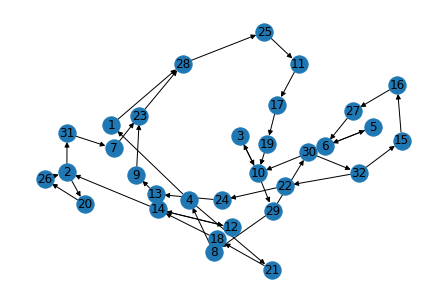

In [32]:
S1E1 = sub_graph_generator(G1E1)
nx.draw(S1E1, with_labels = True)

#### Verificar se é ligado 

In [33]:
nx.is_strongly_connected(S1E1)

True

#### Nº de arestas removidas

In [34]:
print(len(G1E1.edges()) - len(S1E1.edges()))

13


#### Gerar Digrafo - metodo 2

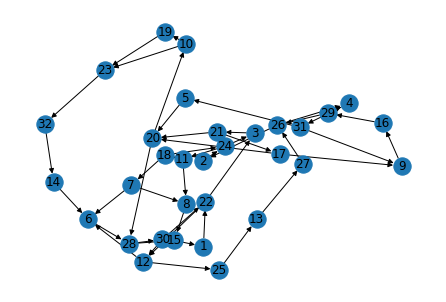

In [35]:
G2E1 = graph_generator_simple()
nx.draw(G2E1, with_labels = True)

#### Verificar se é ligado

In [36]:
nx.is_strongly_connected(G2E1)

True

#### Gerar Subgrafo minimal

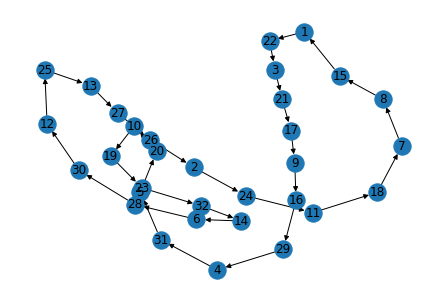

In [37]:
S2E1 = sub_graph_generator(G2E1)
nx.draw(S2E1,with_labels = True)

#### Verificar se é ligado 

In [38]:
nx.is_strongly_connected(S2E1)

True

#### Nº de arestas removidas

In [39]:
print(len(G2E1.edges()) - len(S2E1.edges()))

15


### Exemplo 2

In [40]:
NUM_NODES = 10 
MAX_OUT_DEGREE = 3 

#### Gerar Digrafo - metodo 1

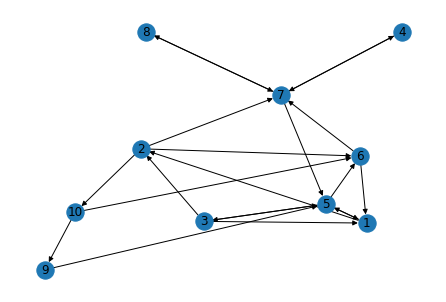

In [41]:
G1E2 = graph_generator()
nx.draw(G1E2, with_labels = True)

#### Verificar se é ligado 

In [42]:
nx.is_strongly_connected(G1E2)

True

#### Gerar Subgrafo minimal

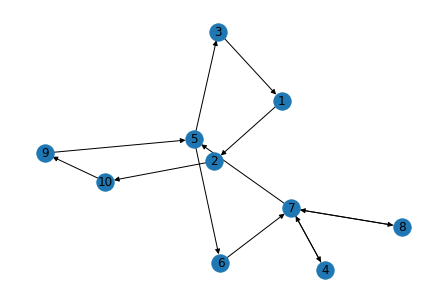

In [43]:
S1E2 = sub_graph_generator(G1E2)
nx.draw(S1E2, with_labels = True)

#### Verificar se é ligado 

In [50]:
nx.is_strongly_connected(S1E2)

True

#### Nº de arestas removidas

In [51]:
print(len(G1E2.edges()) - len(S1E2.edges()))

8


#### Gerar Digrafo - metodo 2

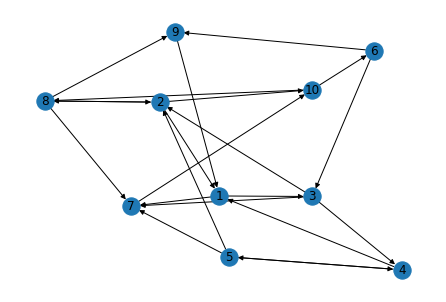

In [46]:
G2E2 = graph_generator_simple()
nx.draw(G2E2, with_labels = True)

#### Verificar se é ligado

In [47]:
nx.is_strongly_connected(G2E2)

True

#### Gerar Subgrafo minimal

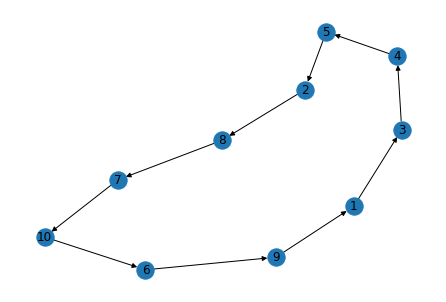

In [49]:
S2E2 = sub_graph_generator(G2E2)
nx.draw(S2E2 ,with_labels = True)

#### Verificar se é ligado 

In [57]:
nx.is_strongly_connected(S2E2)

True

#### Nº de arestas removidas

In [58]:
print(len(G2E2.edges()) - len(S2E2.edges()))

12


### Exemplo 3

In [59]:
NUM_NODES = 15 
MAX_OUT_DEGREE = 3 

#### Gerar Digrafo - metodo 1

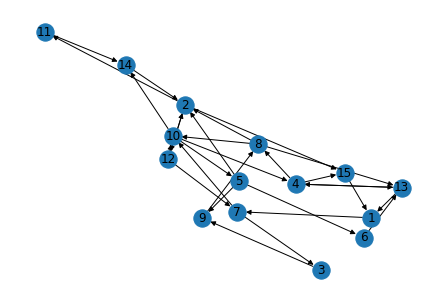

In [60]:
G1E3 = graph_generator()
nx.draw(G1E3, with_labels = True)

#### Verificar se é ligado 

In [61]:
nx.is_strongly_connected(G1E3)

True

#### Gerar Subgrafo minimal

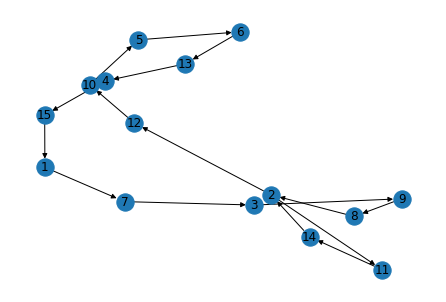

In [62]:
S1E3 = sub_graph_generator(G1E3)
nx.draw(S1E3, with_labels = True)

#### Verificar se é ligado 

In [63]:
nx.is_strongly_connected(S1E3)

True

#### Nº de arestas removidas

In [64]:
print(len(G1E3.edges()) - len(S1E3.edges()))

13


#### Gerar Digrafo - metodo 2

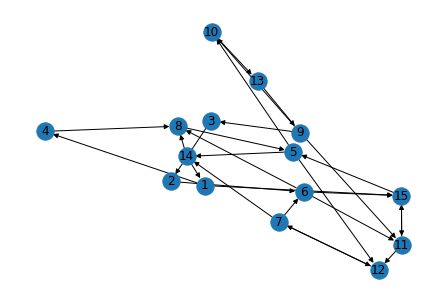

In [65]:
G2E3 = graph_generator_simple()
nx.draw(G2E3, with_labels = True)

#### Verificar se é ligado

In [66]:
nx.is_strongly_connected(G2E3)

True

#### Gerar Subgrafo minimal

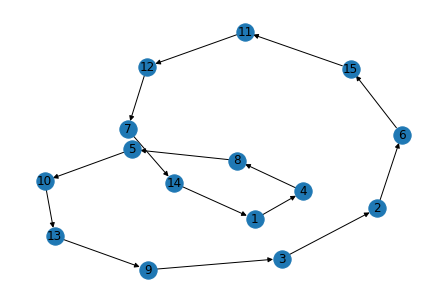

In [67]:
S2E3 = sub_graph_generator(G2E3)
nx.draw(S2E3, with_labels = True)

#### Verificar se é ligado 

In [68]:
nx.is_strongly_connected(S2E3)

True

#### Nº de arestas removidas

In [69]:
print(len(G2E3.edges()) - len(S2E3.edges()))

12
